## x.1 使用矩阵运算加速运算

这一章节主要讲解pytorch的张量带来的矢量化计算，致使计算速度提高

In [1]:

%matplotlib inline
import math
import time
import numpy as np
import torch
from d2l import torch as d2l


n = 10000
a = torch.ones(n)
b = torch.ones(n)



我们比较如果不矢量化计算，即把元素一个一个取出来，逐个相加

矢量化计算，则直接使用加号，不去遍历，速度结果差很多

In [2]:
# 不使用矩阵加速
c = torch.zeros(n)
t = time.time()
for i in range(n):
    c[i] = a[i] + b[i]
f'{time.time() - t:.5f} sec'

'0.26416 sec'

In [3]:
# 使用矩阵加速
t = time.time()
d = a + b
f'{time.time() - t:.5f} sec'

'0.00089 sec'

除此之外，本章还有数学知识，正态分布和平方损失MSE

## x.2 构造一些基础APIs

def add_to_class 用于往类中添加方法和属性

class HyperParamters 当某个子类继承自这个类时候，可以调用该类的def save_hyperparameters(self, ignore=[])方法使形参变为实参

class ProgressBoard 。其中IPython可以通过`pip install ipython`安装，这个方法还依赖matplotlib，只有在notebook上才可以绘图。方法class ProgressBoard是仿造TensorBoard写的进程交互界面

In [27]:
import time
import numpy as np
import torch
from torch import nn
from d2l import torch as d2l

In [28]:
"""
"""
def add_to_class(Class):  #@save
    """Register functions as methods in created class."""
    def wrapper(obj):
        setattr(Class, obj.__name__, obj)
    return wrapper

In [29]:
# test
class A:
    def __init__(self):
        self.b = 1

a = A()

@add_to_class(A)
def do(self):
    print('Class attribute "b" is', self.b)

a.do()

Class attribute "b" is 1


In [30]:
"""
"""
import inspect
class HyperParameters:
    """The base class of hyperparameters."""
    def save_hyperparameters(self, ignore=[]):
        """Defined in :numref:`sec_oo-design`"""
        raise NotImplemented

    def save_hyperparameters(self, ignore=[]):
        """Save function arguments into class attributes.
    
        Defined in :numref:`sec_utils`"""
        frame = inspect.currentframe().f_back
        _, _, _, local_vars = inspect.getargvalues(frame)
        self.hparams = {k:v for k, v in local_vars.items()
                        if k not in set(ignore+['self']) and not k.startswith('_')}
        for k, v in self.hparams.items():
            setattr(self, k, v)

In [31]:
# test
class B(HyperParameters):
    def __init__(self, a, b, c):
        self.save_hyperparameters(ignore=['c'])
        print('self.a =', self.a, 'self.b =', self.b)
        print('There is no self.c =', not hasattr(self, 'c'))

b = B(a=1, b=2, c=3)

self.a = 1 self.b = 2
There is no self.c = True


In [33]:
"""
"""
import collections
from IPython import display
from matplotlib_inline import backend_inline
from matplotlib import pyplot as plt

def use_svg_display():
    """Use the svg format to display a plot in Jupyter.

    Defined in :numref:`sec_calculus`"""
    backend_inline.set_matplotlib_formats('svg')

class ProgressBoard(HyperParameters):
    """The board that plots data points in animation.

    Defined in :numref:`sec_oo-design`"""
    def __init__(self, xlabel=None, ylabel=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 ls=['-', '--', '-.', ':'], colors=['C0', 'C1', 'C2', 'C3'],
                 fig=None, axes=None, figsize=(3.5, 2.5), display=True):
        self.save_hyperparameters()

    def draw(self, x, y, label, every_n=1):
        raise NotImplemented

    def draw(self, x, y, label, every_n=1):
        """Defined in :numref:`sec_utils`"""
        Point = collections.namedtuple('Point', ['x', 'y'])
        if not hasattr(self, 'raw_points'):
            self.raw_points = collections.OrderedDict()
            self.data = collections.OrderedDict()
        if label not in self.raw_points:
            self.raw_points[label] = []
            self.data[label] = []
        points = self.raw_points[label]
        line = self.data[label]
        points.append(Point(x, y))
        if len(points) != every_n:
            return
        mean = lambda x: sum(x) / len(x)
        line.append(Point(mean([p.x for p in points]),
                          mean([p.y for p in points])))
        points.clear()
        if not self.display:
            return
        use_svg_display()
        if self.fig is None:
            self.fig = plt.figure(figsize=self.figsize)
        plt_lines, labels = [], []
        for (k, v), ls, color in zip(self.data.items(), self.ls, self.colors):
            plt_lines.append(plt.plot([p.x for p in v], [p.y for p in v],
                                          linestyle=ls, color=color)[0])
            labels.append(k)
        axes = self.axes if self.axes else plt.gca()
        if self.xlim: axes.set_xlim(self.xlim)
        if self.ylim: axes.set_ylim(self.ylim)
        if not self.xlabel: self.xlabel = self.x
        axes.set_xlabel(self.xlabel)
        axes.set_ylabel(self.ylabel)
        axes.set_xscale(self.xscale)
        axes.set_yscale(self.yscale)
        axes.legend(plt_lines, labels)
        display.display(self.fig)
        display.clear_output(wait=True)

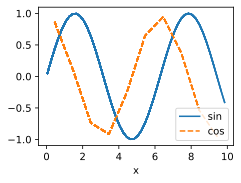

In [34]:
board = ProgressBoard('x')
for x in np.arange(0, 10, 0.1):
    board.draw(x, np.sin(x), 'sin', every_n=2)
    board.draw(x, np.cos(x), 'cos', every_n=10)

## x.3 构建Models模块

The Module class is the base class of all models we will implement. It inherits from `nn.Module`

__init__, stores the learnable parameters

training_step method accepts a data batch to return the loss value

configure_optimizers returns the optimization method, or a list of them, that is used to update the learnable parameters

validation_step to report the evaluation measures.

In [35]:
def cpu():
    """Get the CPU device.

    Defined in :numref:`sec_use_gpu`"""
    return torch.device('cpu')

class Module(nn.Module, HyperParameters):  #@save
    """The base class of models."""
    def __init__(self, plot_train_per_epoch=2, plot_valid_per_epoch=1):
        super().__init__()
        self.save_hyperparameters()
        self.board = ProgressBoard()

    def loss(self, y_hat, y):
        raise NotImplementedError

    def forward(self, X):
        assert hasattr(self, 'net'), 'Neural network is defined'
        return self.net(X)

    def plot(self, key, value, train):
        """Plot a point in animation."""
        assert hasattr(self, 'trainer'), 'Trainer is not inited'
        self.board.xlabel = 'epoch'
        if train:
            x = self.trainer.train_batch_idx / \
                self.trainer.num_train_batches
            n = self.trainer.num_train_batches / \
                self.plot_train_per_epoch
        else:
            x = self.trainer.epoch + 1
            n = self.trainer.num_val_batches / \
                self.plot_valid_per_epoch
        self.board.draw(x, value.to(cpu()).detach().numpy(),
                        ('train_' if train else 'val_') + key,
                        every_n=int(n))

    def training_step(self, batch):
        l = self.loss(self(*batch[:-1]), batch[-1])
        self.plot('loss', l, train=True)
        return l

    def validation_step(self, batch):
        l = self.loss(self(*batch[:-1]), batch[-1])
        self.plot('loss', l, train=False)

    def configure_optimizers(self):
        raise NotImplementedError

## x.4 构建Data模块

The DataModule class is the base class for data.

__init__ method is used to prepare the data. This includes downloading and preprocessing if needed.

train_dataloader returns the data loader for the training dataset. A data loader is a (Python) generator that yields a data batch each time it is used. This batch is then fed into the training_step method of Module to compute the loss.

There is an optional val_dataloader to return the validation dataset loader.

In [36]:
class DataModule(HyperParameters):  #@save
    """The base class of data."""
    def __init__(self, root='../data', num_workers=4):
        self.save_hyperparameters()

    def get_dataloader(self, train):
        raise NotImplementedError

    def train_dataloader(self):
        return self.get_dataloader(train=True)

    def val_dataloader(self):
        return self.get_dataloader(train=False)
    
    # add
    def get_tensorloader(self, tensors, train, indices=slice(0, None)):
        """Defined in :numref:`sec_synthetic-regression-data`"""
        tensors = tuple(a[indices] for a in tensors)
        dataset = torch.utils.data.TensorDataset(*tensors)
        return torch.utils.data.DataLoader(dataset, self.batch_size,
                                           shuffle=train)

## x.5 构建Training模块

The Trainer class trains the learnable parameters in the Module class with data specified in DataModule. 

The key method is fit, which accepts two arguments: model, an instance of Module, and data, an instance of DataModule. It then iterates over the entire dataset max_epochs times to train the model. 

In [37]:
class Trainer(HyperParameters):  #@save
    """The base class for training models with data."""
    def __init__(self, max_epochs, num_gpus=0, gradient_clip_val=0):
        self.save_hyperparameters()
        assert num_gpus == 0, 'No GPU support yet'

    def prepare_data(self, data):
        self.train_dataloader = data.train_dataloader()
        self.val_dataloader = data.val_dataloader()
        self.num_train_batches = len(self.train_dataloader)
        self.num_val_batches = (len(self.val_dataloader)
                                if self.val_dataloader is not None else 0)
    
    # add
    def prepare_batch(self, batch):
        raise NotImplementedError
    
    def prepare_model(self, model):
        model.trainer = self
        model.board.xlim = [0, self.max_epochs]
        self.model = model

    def fit(self, model, data):
        self.prepare_data(data)
        self.prepare_model(model)
        self.optim = model.configure_optimizers()
        self.epoch = 0
        self.train_batch_idx = 0
        self.val_batch_idx = 0
        for self.epoch in range(self.max_epochs):
            self.fit_epoch()

    def fit_epoch(self):
        raise NotImplementedError

注意，当一个类中有两个init方法时，第二个方法会覆盖第一个方法，只有第二个会被调用

## x.6 制造Data

In [38]:
%matplotlib inline
import random
import torch
from d2l import torch as d2l

In [39]:
# init data
class SyntheticRegressionData(DataModule):  #@save
    """Synthetic data for linear regression."""
    def __init__(self, w, b, noise=0.01, num_train=1000, num_val=1000,
                 batch_size=32):
        super().__init__()
        self.save_hyperparameters()
        n = num_train + num_val
        self.X = torch.randn(n, len(w))
        noise = torch.randn(n, 1) * noise
        self.y = torch.matmul(self.X, w.reshape((-1, 1))) + b + noise

In [40]:
data = SyntheticRegressionData(w=torch.tensor([2, -3.4]), b=4.2)

In [41]:
print('features:', data.X[0],'\nlabel:', data.y[0])

features: tensor([-0.2735, -0.7856]) 
label: tensor([6.3255])


In [42]:
data.X.shape, data.y.shape  # 最终我们定义了2000组数据，其中signal有2000个sample，1个sample有2个features，label有与之对应的2000个sample，（2000， 1）

(torch.Size([2000, 2]), torch.Size([2000, 1]))

## x.6.1 manual dataset and dataloader

In [43]:
# read data
@add_to_class(SyntheticRegressionData)
def get_dataloader(self, train):
    if train:
        indices = list(range(0, self.num_train))
        # The examples are read in random order
        random.shuffle(indices)
    else:
        indices = list(range(self.num_train, self.num_train+self.num_val))
    for i in range(0, len(indices), self.batch_size):
        batch_indices = torch.tensor(indices[i: i+self.batch_size])
        yield self.X[batch_indices], self.y[batch_indices]

In [44]:
X, y = next(iter(data.train_dataloader()))
print('X shape:', X.shape, '\ny shape:', y.shape)
len(data.train_dataloader())

X shape: torch.Size([32, 2]) 
y shape: torch.Size([32, 1])


TypeError: object of type 'generator' has no len()

## x.6.2 concise dataset and dataloader

In [21]:
@add_to_class(DataModule)  #@save
def get_tensorloader(self, tensors, train, indices=slice(0, None)):
    tensors = tuple(a[indices] for a in tensors)
    dataset = torch.utils.data.TensorDataset(*tensors)
    return torch.utils.data.DataLoader(dataset, self.batch_size,
                                       shuffle=train)

@add_to_class(SyntheticRegressionData)  #@save
def get_dataloader(self, train):
    i = slice(0, self.num_train) if train else slice(self.num_train, None)
    return self.get_tensorloader((self.X, self.y), train, i)

In [22]:
X, y = next(iter(data.train_dataloader()))
print('X shape:', X.shape, '\ny shape:', y.shape)

X shape: torch.Size([32, 2]) 
y shape: torch.Size([32, 1])


In [23]:
len(data.train_dataloader())

32

## x.7 manual model

In [26]:
%matplotlib inline
import torch
from d2l import torch as d2l

In [27]:
class LinearRegressionScratch(Module):  #@save
    """The linear regression model implemented from scratch."""
    def __init__(self, num_inputs, lr, sigma=0.01):
        super().__init__()
        self.save_hyperparameters()
        self.w = torch.normal(0, sigma, (num_inputs, 1), requires_grad=True)
        self.b = torch.zeros(1, requires_grad=True)

### x.7.1 增加正向传播过程

In [28]:
@add_to_class(LinearRegressionScratch)  #@save
def forward(self, X):
    return torch.matmul(X, self.w) + self.b

### x.7.2 增加损失函数cost

In [29]:
@add_to_class(LinearRegressionScratch)  #@save
def loss(self, y_hat, y):
    l = (y_hat - y) ** 2 / 2
    return l.mean()

### x.7.3 增加model的优化算法

In [30]:
class SGD(HyperParameters):  #@save
    """Minibatch stochastic gradient descent."""
    def __init__(self, params, lr):
        self.save_hyperparameters()

    def step(self):
        for param in self.params:
            param -= self.lr * param.grad

    def zero_grad(self):
        for param in self.params:
            if param.grad is not None:
                param.grad.zero_()

In [31]:
@add_to_class(LinearRegressionScratch)  #@save
def configure_optimizers(self):
    return SGD([self.w, self.b], self.lr)

## x.8 Trainer

Trainer只能自己设置，所以无所谓manual或者concise

在这一步其实我们只要做两件事，

第一件事是初始化参数

第二件事是每一轮次更新参数

In [32]:
@add_to_class(Trainer)  #@save
def prepare_batch(self, batch):
    return batch

@add_to_class(Trainer)  #@save
def fit_epoch(self):
    self.model.train()
    for batch in self.train_dataloader:
        loss = self.model.training_step(self.prepare_batch(batch))
        self.optim.zero_grad()
        with torch.no_grad():
            loss.backward()
            if self.gradient_clip_val > 0:  # To be discussed later
                self.clip_gradients(self.gradient_clip_val, self.model)
            self.optim.step()
        self.train_batch_idx += 1
    if self.val_dataloader is None:
        return
    self.model.eval()
    for batch in self.val_dataloader:
        with torch.no_grad():
            self.model.validation_step(self.prepare_batch(batch))
        self.val_batch_idx += 1

## x.9 main函数中的开始训练

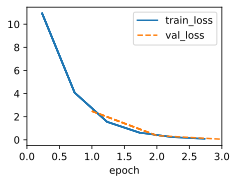

In [33]:
## x.9 main函数中的开始训练
model = LinearRegressionScratch(2, lr=0.03)
data = SyntheticRegressionData(w=torch.tensor([2, -3.4]), b=4.2)
trainer = Trainer(max_epochs=3)
trainer.fit(model, data)

In [34]:
with torch.no_grad():
    print(f'error in estimating w: {data.w - model.w.reshape(data.w.shape)}')
    print(f'error in estimating b: {data.b - model.b}')

error in estimating w: tensor([ 0.0645, -0.1964])
error in estimating b: tensor([0.2365])


## x.10 concise model

In [35]:
import numpy as np
import torch
from torch import nn
from d2l import torch as d2l

In [36]:
class LinearRegression(Module):  #@save
    """The linear regression model implemented with high-level APIs."""
    def __init__(self, lr):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.LazyLinear(1)
        # 参数初始化
        self.net.weight.data.normal_(0, 0.01)
        self.net.bias.data.fill_(0)

In [37]:
@add_to_class(LinearRegression)  #@save
def forward(self, X):
    return self.net(X)

In [38]:
@add_to_class(LinearRegression)  #@save
def loss(self, y_hat, y):
    fn = nn.MSELoss()
    return fn(y_hat, y)

In [39]:
@add_to_class(LinearRegression)  #@save
def configure_optimizers(self):
    return torch.optim.SGD(self.parameters(), self.lr)

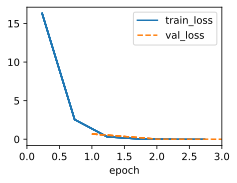

In [40]:
model = LinearRegression(lr=0.03)
data = SyntheticRegressionData(w=torch.tensor([2, -3.4]), b=4.2)
trainer = Trainer(max_epochs=3)
trainer.fit(model, data)

In [41]:
@add_to_class(LinearRegression)  #@save
def get_w_b(self):
    return (self.net.weight.data, self.net.bias.data)
w, b = model.get_w_b()

print(f'error in estimating w: {data.w - w.reshape(data.w.shape)}')
print(f'error in estimating b: {data.b - b}')

error in estimating w: tensor([ 0.0094, -0.0089])
error in estimating b: tensor([0.0103])


## x.11 manual L2 loss, that is Weight Decay

In [42]:
class Data(DataModule):
    def __init__(self, num_train, num_val, num_inputs, batch_size):
        self.save_hyperparameters()
        n = num_train + num_val
        self.X = torch.randn(n, num_inputs)
        noise = torch.randn(n, 1) * 0.01
        w, b = torch.ones((num_inputs, 1)) * 0.01, 0.05
        self.y = torch.matmul(self.X, w) + b + noise

    def get_dataloader(self, train):
        i = slice(0, self.num_train) if train else slice(self.num_train, None)
        return self.get_tensorloader([self.X, self.y], train, i)

In [43]:
def l2_penalty(w):
    return (w ** 2).sum() / 2

In [44]:
class WeightDecayScratch(d2l.LinearRegressionScratch):
    def __init__(self, num_inputs, lambd, lr, sigma=0.01):
        super().__init__(num_inputs, lr, sigma)
        self.save_hyperparameters()

    def loss(self, y_hat, y):
        return (super().loss(y_hat, y) +
                self.lambd * l2_penalty(self.w))

In [45]:
data = Data(num_train=20, num_val=100, num_inputs=200, batch_size=5)
trainer = d2l.Trainer(max_epochs=10)

def train_scratch(lambd):
    model = WeightDecayScratch(num_inputs=200, lambd=lambd, lr=0.01)
    model.board.yscale='log'
    trainer.fit(model, data)
    print('L2 norm of w:', float(l2_penalty(model.w)))

L2 norm of w: 0.010285424999892712


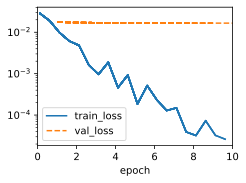

In [46]:
train_scratch(0)

L2 norm of w: 0.0016293404623866081


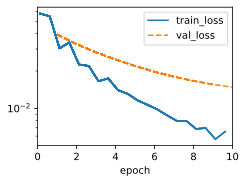

In [47]:
train_scratch(3)

## x.12 consice weight decay

In [48]:
class WeightDecay(d2l.LinearRegression):
    def __init__(self, wd, lr):
        super().__init__(lr)
        self.save_hyperparameters()
        self.wd = wd

    def configure_optimizers(self):
        return torch.optim.SGD([
            {'params': self.net.weight, 'weight_decay': self.wd},
            {'params': self.net.bias}], lr=self.lr)

L2 norm of w: 0.01410625223070383


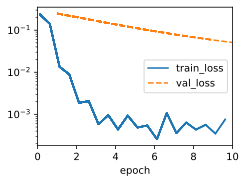

In [49]:
model = WeightDecay(wd=3, lr=0.01)
model.board.yscale='log'
trainer.fit(model, data)

print('L2 norm of w:', float(l2_penalty(model.get_w_b()[0])))